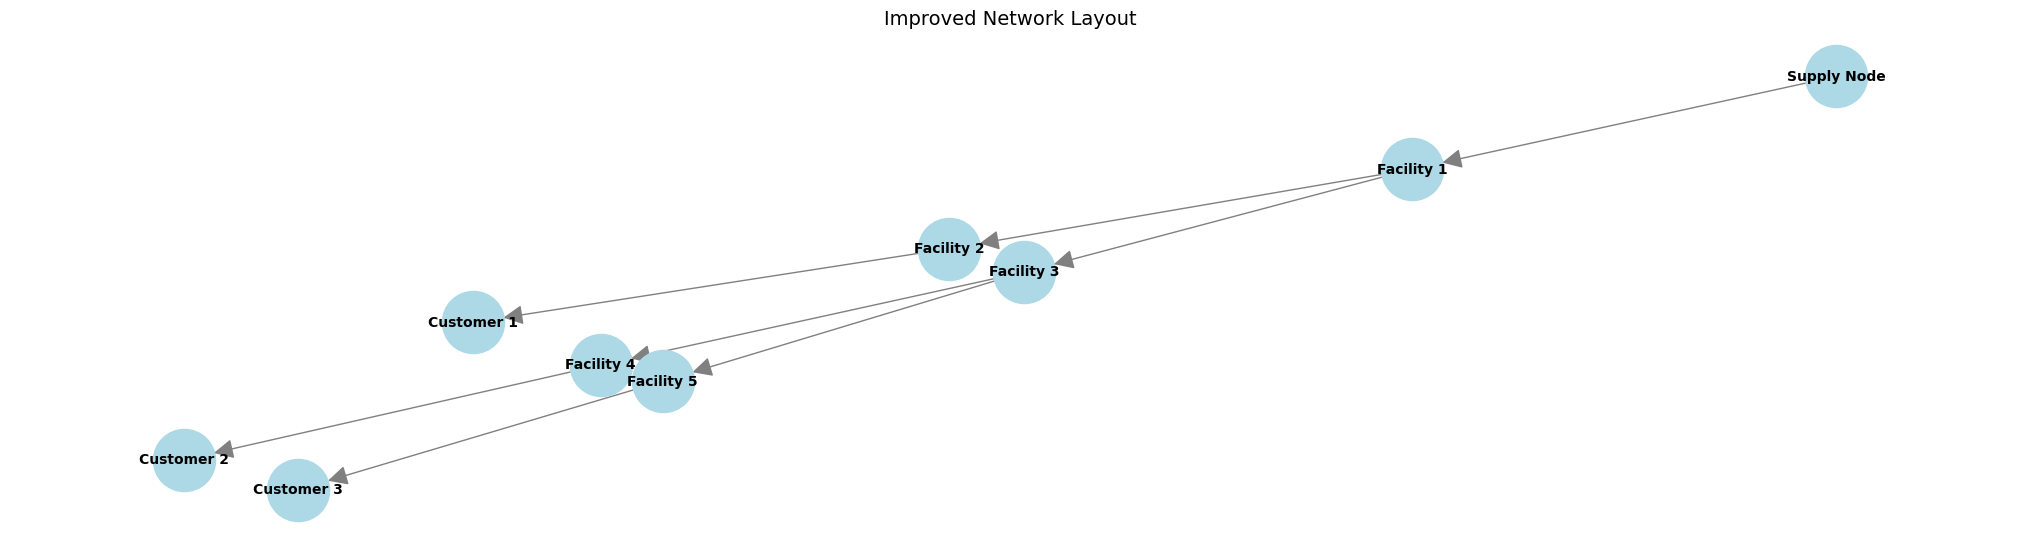

In [90]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.DiGraph()

# Add nodes
G.add_node("Supply Node")
G.add_nodes_from(["Facility 1", "Facility 2", "Facility 3", "Facility 4", "Facility 5"])
G.add_nodes_from(["Customer 1", "Customer 2", "Customer 3"])

# Add edges
G.add_edge("Supply Node", "Facility 1")
G.add_edge("Facility 1", "Facility 2")
G.add_edge("Facility 1", "Facility 3")
G.add_edge("Facility 3", "Facility 4")
G.add_edge("Facility 3", "Facility 5")
G.add_edge("Facility 2", "Customer 1")
G.add_edge("Facility 4", "Customer 2")
G.add_edge("Facility 5", "Customer 3")

# Use Kamada-Kawai layout for better visualization
pos = nx.kamada_kawai_layout(G)

# Draw the network
plt.figure(figsize=(20, 5))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    edge_color="gray",
    arrowsize=30,
)
plt.title("Improved Network Layout", fontsize=14)
plt.show()

In [1]:
# from stockpyl.supply_chain_network import serial_system
# from stockpyl.ssm_serial import optimize_base_stock_levels
# # Stockpyl includes an implementation of the Clark and Scarf (1960) algorithm for stochastic serial systems 
# # (or, more precisely, Chen and Zheng’s (1994) reworking of it
# network = serial_system(num_nodes=5,
#                         node_order_in_system=[1,2,3,4,5],
#                         node_order_in_lists=[1,2,3,4,5],
#                         local_holding_cost=[10,6,15,25,25],
#                         shipment_lead_time=[1,1,1,2,4],
#                         stockout_cost=50,
#                         demand_type='N',
#                         mean=10,
#                         standard_deviation=2,
#                         echelon_holding_cost=2
#                         )
# S_star, C_star = optimize_base_stock_levels(network=network)
# S_star #Optimal base-stock level
# C_star #Optimal expected cost

In [ ]:
import math
from stockpyl.supply_chain_network import SupplyChainNetwork
from stockpyl.supply_chain_node import SupplyChainNode
from stockpyl.demand_source import DemandSource
from stockpyl.gsm_tree import optimize_committed_service_times

# Assuming ordering cost (S) is a fixed value for simplicity
ordering_cost = 100  # Example ordering cost

# Function to calculate EOQ (Base Order)
def calculate_economical_order_quantity(demand_mean, holding_cost):
    return math.sqrt((2 * demand_mean * ordering_cost) / holding_cost)

# Function to calculate Reorder Point
def calculate_reorder_point(demand_mean, lead_time, safety_stock_factor=1):
    # Safety Stock is typically based on demand variability (standard deviation) and a service level factor.
    # For simplicity, let's assume safety stock as a fraction of demand's standard deviation.
    safety_stock = safety_stock_factor * demand_mean
    reorder_point = demand_mean * lead_time + safety_stock
    return reorder_point

# Create the supply chain network
network = SupplyChainNetwork()

# Define nodes
supply_node = SupplyChainNode(index=0, name="Supply Node", processing_time=0, external_inbound_cst=0, local_holding_cost=0, supply_type='U')
facility_1 = SupplyChainNode(index=1, name="Facility 1", processing_time=1, external_inbound_cst=1, local_holding_cost=1, demand_source=DemandSource(type='N', mean=49.53981839, standard_deviation=49.25559437))
facility_2 = SupplyChainNode(index=2, name="Facility 2", processing_time=2, external_inbound_cst=1, local_holding_cost=1, demand_source=DemandSource(type='N', mean=19.71722985, standard_deviation=19.6515767))
facility_3 = SupplyChainNode(index=3, name="Facility 3", processing_time=2, external_inbound_cst=0, local_holding_cost=5)
facility_4 = SupplyChainNode(index=4, name="Facility 4", processing_time=4, external_inbound_cst=4, local_holding_cost=1, demand_source=DemandSource(type='N', mean=9.79358216, standard_deviation=9.867354557))
facility_5 = SupplyChainNode(index=5, name="Facility 5", processing_time=5, external_inbound_cst=4, local_holding_cost=1, demand_source=DemandSource(type='N', mean=19.91306668, standard_deviation=19.91003392))

# Add nodes to the network
network.add_node(supply_node)
network.add_node(facility_1)
network.add_node(facility_2)
network.add_node(facility_3)
network.add_node(facility_4)
network.add_node(facility_5)

# Add edges to the network (from one node to another)
network.add_edge(from_index=0, to_index=1)  # Supply Node → Facility 1
network.add_edge(from_index=1, to_index=2)  # Facility 1 → Facility 2
network.add_edge(from_index=1, to_index=3)  # Facility 1 → Facility 3
network.add_edge(from_index=3, to_index=4)  # Facility 3 → Facility 4
network.add_edge(from_index=3, to_index=5)  # Facility 3 → Facility 5

# Print the network structure
print("Supply Chain Network Structure:")
for node in network.nodes:
    print(f"Node {node.index} ({node.name})")

# Optimize committed service times
opt_cst, opt_cost = optimize_committed_service_times(tree=network)

# Print the results
print("\nOptimized Committed Service Times:")
for node_index, cst in opt_cst.items():
    node = network.nodes_by_index[node_index]
    print(f"Node {node.name}: Committed Service Time = {cst}")

print(f"\nTotal Optimized Cost: {opt_cost}")

# Calculate and print Base Order and Reorder Point for each node
for node in network.nodes:
    try:
        # Extract the node's properties
        demand_mean = node.demand_source.mean if node.demand_source else 0
        demand_std = node.demand_source.standard_deviation if node.demand_source else 0
        holding_cost = node.local_holding_cost
        lead_time = node.external_inbound_cst  # Using external_inbound_cst as a proxy for lead time
        
        # Calculate Base Order (EOQ)
        eoq = calculate_economical_order_quantity(demand_mean, holding_cost) if demand_mean > 0 else 0
        
        # Calculate Reorder Point
        reorder_point = calculate_reorder_point(demand_mean, lead_time, safety_stock_factor=2) if demand_mean > 0 else 0
        
        # Print results
        print(f"\nNode {node.name}:")
        print(f"  Base Order (EOQ): {eoq:.2f}")
        print(f"  Reorder Point: {reorder_point:.2f}")
    except:
        pass


Supply Chain Network Structure:
Node 0 (Supply Node)
Node 1 (Facility 1)
Node 2 (Facility 2)
Node 3 (Facility 3)
Node 4 (Facility 4)
Node 5 (Facility 5)

Optimized Committed Service Times:
Node Supply Node: Committed Service Time = 0
Node Facility 1: Committed Service Time = 2
Node Facility 2: Committed Service Time = 4
Node Facility 3: Committed Service Time = 4
Node Facility 4: Committed Service Time = 8
Node Facility 5: Committed Service Time = 9

Total Optimized Cost: 0.0

Node Facility 1:
  Base Order (EOQ): 99.54
  Reorder Point: 148.62

Node Facility 2:
  Base Order (EOQ): 62.80
  Reorder Point: 59.15

Node Facility 4:
  Base Order (EOQ): 44.26
  Reorder Point: 58.76

Node Facility 5:
  Base Order (EOQ): 63.11
  Reorder Point: 119.48


In [8]:
# # Extract the node's properties
demand_mean = 14.85332442
demand_std = 16.50721236
holding_cost = network.nodes[3].local_holding_cost
lead_time = network.nodes[3].external_inbound_cst  # Using external_inbound_cst as a proxy for lead time

# # Calculate Base Order (EOQ)
eoq = calculate_economical_order_quantity(demand_mean, holding_cost) if demand_mean > 0 else 0

# # Calculate Reorder Point
reorder_point = calculate_reorder_point(demand_mean, lead_time, safety_stock_factor=2) if demand_mean > 0 else 0

# # Print results
print(f"\nNode {network.nodes[3].name}:")
print(f"  Base Order (EOQ): {eoq:.2f}")
print(f"  Reorder Point: {reorder_point:.2f}")


Node Facility 3:
  Base Order (EOQ): 44.50
  Reorder Point: 29.71


In [2]:
from stockpyl.supply_chain_network import network_from_edges
from stockpyl.gsm_tree import optimize_committed_service_times
from stockpyl.sim import simulation
from stockpyl.sim_io import write_results

# Define the corrected network
network = network_from_edges(
    edges=[(1, 2), (1, 3), (3, 4), (3, 5)],  # Edges representing the flow
    node_order_in_lists=[1, 2, 3, 4, 5],  # Node indices
    local_holding_cost=[1, 4, 2, 5, 5],  # Holding costs for each node
    stockout_cost=[1, 4, 1, 5, 6],  # Stockout costs (adjust as necessary)
    order_lead_time=[5, 2, 2, 1, 1],  # Order processing times for nodes
    shipment_lead_time=[1, 2, 1, 6, 4],  # Shipment lead times for edges
    demand_type=['P', 'P', None, 'P', 'P'],  # Correct demand types
    mean=[49.54, 19.72, None, 9.79, 19.91],  # Valid demand means
    policy_type=['BS', 'BS', 'BS', 'BS', 'BS'],  # Policies for each node
    base_stock_level=[3000, 2500, 2000, 1000, 1000]  # Base stock levels
)

# Run simulation and write results
simulation(network=network,rand_seed=200, num_periods=365)

100%|██████████| 365/365 [00:00<00:00, 558.09it/s]


9280494.0

In [3]:
write_results(network, num_periods=365,columns_to_print=['OQ','IL','DMFS','ISPL'],write_csv=True,csv_filename='BASE_OREDER_QTY__REORDER_POINT.csv')

  t  | i=1      OQ:EXT  ISPL:EXT                                      DMFS    IL  | i=2      OQ:1  ISPL:1                DMFS    IL  | i=3      OQ:1  ISPL:1          DMFS    IL  | i=4      OQ:3  ISPL:3                                     DMFS    IL  | i=5      OQ:3  ISPL:3                         DMFS    IL
---  -------  --------  ------------------------------------------  ------  ----  -------  ------  ------------------  ------  ----  -------  ------  ------------  ------  ----  -------  ------  ---------------------------------------  ------  ----  -------  ------  ---------------------------  ------  ----
  0  |              65  [0, 0, 0, 0, 0, 65.0]                           65  2935  |            21  [0, 0, 0, 0]            21  2479  |             0  [0, 0, 0]          0  2000  |            11  [0, 0, 0, 0, 0, 0, 0]                        11   989  |            24  [0, 0, 0, 0, 0]                  24   976
  1  |              57  [0, 0, 0, 0, 65.0, 57.0]                        5

In [243]:
import os

In [244]:
os.getcwd()

'c:\\Users\\Transorg\\AppData\\Local\\Programs\\Microsoft VS Code'